In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from PIL import Image

import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

#from tqdm import tqdm
from tqdm.notebook import tqdm

from torchviz import make_dot

from torchmetrics import Recall, Precision, F1Score

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [3]:
base_path = "C:\\Users\\johnn\\Desktop\\Repos\\Capstonfire\\FIRE Dataset"

In [4]:
class FireDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        # Store the folder names in a dictionary as the class names alongside the class numeric label
        self.class_to_idx = {} 
        for i, cls in enumerate(self.classes):
            self.class_to_idx[cls] = i

        self.data = self._load_data()

    def _load_data(self):
        data = []
        for class_name in self.classes: # Fetch the folders through the class name
            class_path = os.path.join(self.root_dir, class_name)
            for filename in os.listdir(class_path): # Fetch the images inside each folders
                img_path = os.path.join(class_path, filename) # Obtain the name of the current image
                data.append((img_path, self.class_to_idx[class_name])) # Add the image to a list paired with its class' numeric label
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label

Label: 0
Image shape: torch.Size([3, 256, 256])


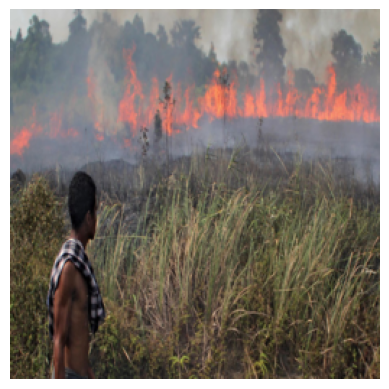

In [5]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.to(device))
])

dataset = FireDataset(base_path, transform=transform)

# Access an image and its label
img, label = dataset[0]
print("Label:", label)
# The image is a PyTorch tensor
print("Image shape:", img.shape)

# Convert the PyTorch tensor to a NumPy array and permute dimensions if necessary
img_np = img.detach().cpu().numpy() if img.is_cuda else img.numpy()

img_np = np.transpose(img_np, (1, 2, 0))

# Display the image using Matplotlib
plt.imshow(img_np)
plt.axis('off')
plt.show()

In [6]:
batch_size = 50

In [14]:
train_size = 0.7
val_size = 0.2
test_size = 0.1

train_dataset, val_dataset, test_dataset = random_split(dataset=dataset, lengths=[train_size, val_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
len(train_loader.dataset)

700

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=3) # to capture basic patterns from the image
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)# to capture basic patterns from the previous patterns (results in capturing more complex patterns from the original image)
        self.conv3 = nn.Conv2d(20, 10, kernel_size=3)
        self.fc1 = nn.Linear(10*30*30, 50) # 9000 = number of channels of the last Conv2D (10) * width obtained from the kernels (30) * height (30)
        self.fc2 = nn.Linear(50, 2) # DNN > WNN; also 2 classes

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, 10*30*30)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #return F.log_softmax(x, dim=1)
        return x

model = SimpleCNN().to(device)

In [10]:
torch.cuda.empty_cache()

In [17]:
x = torch.randn(50, 3, 256, 256).to(device)  # A dummy input tensor to pass through the model
y = model(x)

dot = make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))
dot.render('model details/model_visualization', format='png')

'model details\\model_visualization.png'

In [18]:
# Dummy dataset
dummy_data = torch.randn((50, 3, 256, 256)).to(device)  # 100 samples, 3 channels, 256x256 images
dummy_labels = torch.randint(0, 2, (50,))  # 50 labels, assuming 2 classes

# Create a TensorDataset
dummy_dataset = TensorDataset(dummy_data, dummy_labels)

# Create a DataLoader for the dummy dataset
dummy_dataloader = DataLoader(dummy_dataset, batch_size=64, shuffle=True)

# Pass the dummy DataLoader through the model
for batch_idx, (images, labels) in enumerate(dummy_dataloader):
    outputs = model(images)
    # Your further processing here
    print("Batch:", batch_idx, "Output shape:", outputs.shape)

Batch: 0 Output shape: torch.Size([50, 2])


In [19]:
# Step 2: Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0003, momentum=0.9)


# Step 3: Training Loop
num_epochs = 20
for epoch in tqdm(list(range(num_epochs))):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # zero the parameter gradients
        outputs = model(inputs)  # forward
        loss = criterion(outputs, labels)  # calculate loss
        loss.backward()  # backward
        optimizer.step()  # optimize
        
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

  0%|          | 0/20 [00:00<?, ?it/s]

Finished Training


In [ ]:
model.parameters(recurse=True)

<generator object Module.parameters at 0x000001971C91C900>